In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO:
<!-- 1. Add kinematic visocisty -->
<!-- 2. Backport velocity diffusion to DFSPH code (own module) -->
3. IMPROVE PERFORMANCE
4. Add drag forces
5. delta sph with boundary integrals?!
6. setup dambreak with obstacle
7. setup flow past cylinder
8. add wcsph (müller)
9. add compressible sph
10. setup shockwave scenario for compressible sph

In [3]:
# from src.deltaSPH import deltaSPHSimulation

In [4]:
from src.deltaSPH import deltaSPHSimulation
from src.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

In [5]:
velocities = []

r = 2
for i in range(8):
#     for j in range(8):
    theta_i = 2 * np.pi * i / 8
    xi = r * np.cos(theta_i)
    yi = r * np.sin(theta_i)
    
    velocities.append(np.array([xi,yi]))
    
#     debugPrint(xi)
debugPrint(velocities)

velocities [list] = [array([2., 0.]), array([1.41421356, 1.41421356]), array([1.2246468e-16, 2.0000000e+00]), array([-1.41421356,  1.41421356]), array([-2.0000000e+00,  2.4492936e-16]), array([-1.41421356, -1.41421356]), array([-3.6739404e-16, -2.0000000e+00]), array([ 1.41421356, -1.41421356])]


In [6]:
r = 1
r1 = 0.25
r2 = 0.125

theta1 = np.random.rand(1) * np.pi * 2
# theta2 = np.random.rand(1) * np.pi * 1.5 + theta1
theta2 = theta1 + np.pi + np.random.normal(0,np.pi/4)
offset1 = np.random.normal(0,0.5)
offset2 = np.random.normal(0,0.5)
# print(offset1)
vel1 = np.random.normal(1,0.125)
vel2 = np.random.normal(1,0.125)
# print(vel1, vel2)


In [7]:
p1 = np.array([np.cos(theta1) * r, np.sin(theta1) * r])
p2 = np.array([np.cos(theta2) * r, np.sin(theta2) * r])
x1 = np.array([np.cos(theta1) * r, np.sin(theta1) * r])
x2 = np.array([np.cos(theta2) * r, np.sin(theta2) * r])

dir1 = p1 / np.linalg.norm(p1)
dir2 = p2 / np.linalg.norm(p2)
orth1 = np.array([-dir1[1],dir1[0]]) / np.linalg.norm(dir1)
orth2 = np.array([-dir2[1],dir2[0]]) / np.linalg.norm(dir2)

# p1 = p1 + orth1 * offset1 * r1
# p2 = p2 + orth2 * offset2 * r2


def intersect(p1, dir1, p2, dir2):
    x  = (-p2[0] + (-p1[1]  + p2[1]) /  dir2[1] * dir2[0] + p1[0]) / (dir1[0] - dir1[1] /  dir2[1] * dir2[0])
    return x, (p1 - dir1 * x)[:,0]

i1, ip1 = intersect(p1, dir1, p2, dir2)
# print(p1[:,0], np.linalg.norm(p1))
# print(ip1, np.linalg.norm(ip1))

dist1 = np.linalg.norm(ip1 - p1[:,0])
dist2 = np.linalg.norm(ip1 - p2[:,0])
# print(dist1, dist2)

shifted1 = p1 - dir1 * (dist1 - vel1)
shifted2 = p2 - dir2 * (dist2 - vel2)

intersect21 = sorted([intersect(shifted1 + orth1 * offset1 * r1, dir1, shifted2, dir2)[0][0], intersect(shifted1 - orth1 * offset1 * r1, dir1, shifted2, dir2)[0][0]])
# print(intersect21)
# print(intersect21[0]/vel1)
# print(intersect21[1]/vel1)

offset = np.random.rand() * (intersect21[1]/vel1 - intersect21[0]/vel1) + intersect21[0]/vel1
# print(offset)

dist1 = np.linalg.norm(ip1 - p1[:,0])
shifted1 = p1 - dir1 * (dist1 - offset)

i,ip = intersect(shifted1, dir1, shifted2, dir2)
print(i, ip)

[1.04037072] [-2.77555756e-17  2.22044605e-16]


In [485]:
angle = np.arccos(dir1.T@dir2)
print(angle)
a = r2 / np.sin(angle)
a2 = r1 / np.sin(angle)
print(a)

[[2.07868252]]
[[0.14305751]]


In [491]:


intersect1 = sorted([intersect(shifted1 + orth1 * offset1 * r1, dir1, p2, dir2)[0][0], intersect(shifted1 - orth1 * offset1 * r1, dir1, p2, dir2)[0][0]])
intersect2 = sorted([intersect(shifted2 + orth2 * offset2 * r2, dir2, p1, dir1)[0][0], intersect(shifted2 - orth2 * offset2 * r2, dir2, p1, dir1)[0][0]])

def intersect(p1, dir1, p2, dir2):
    x  = (-p2[0] + (-p1[1]  + p2[1]) /  dir2[1] * dir2[0] + p1[0]) / (dir1[0] - dir1[1] /  dir2[1] * dir2[0])
    return x, (p1 - dir1 * x)[:,0]


intersect1 = sorted([intersect(p1, dir1, p2 + orth2 * r2, dir2)[0][0], intersect(p1, dir1, p2 - orth2 * r2, dir2)[0][0]])
intersect2 = sorted([intersect(p2, dir2, p1 + orth1 * r1, dir1)[0][0], intersect(p2, dir2, p1 - orth1 * r1, dir1)[0][0]])
print(intersect2)

[0.7138849794372509, 1.286115020562749]


iFirst [ 0.32001571 -0.28597029]


<IPython.core.display.Javascript object>


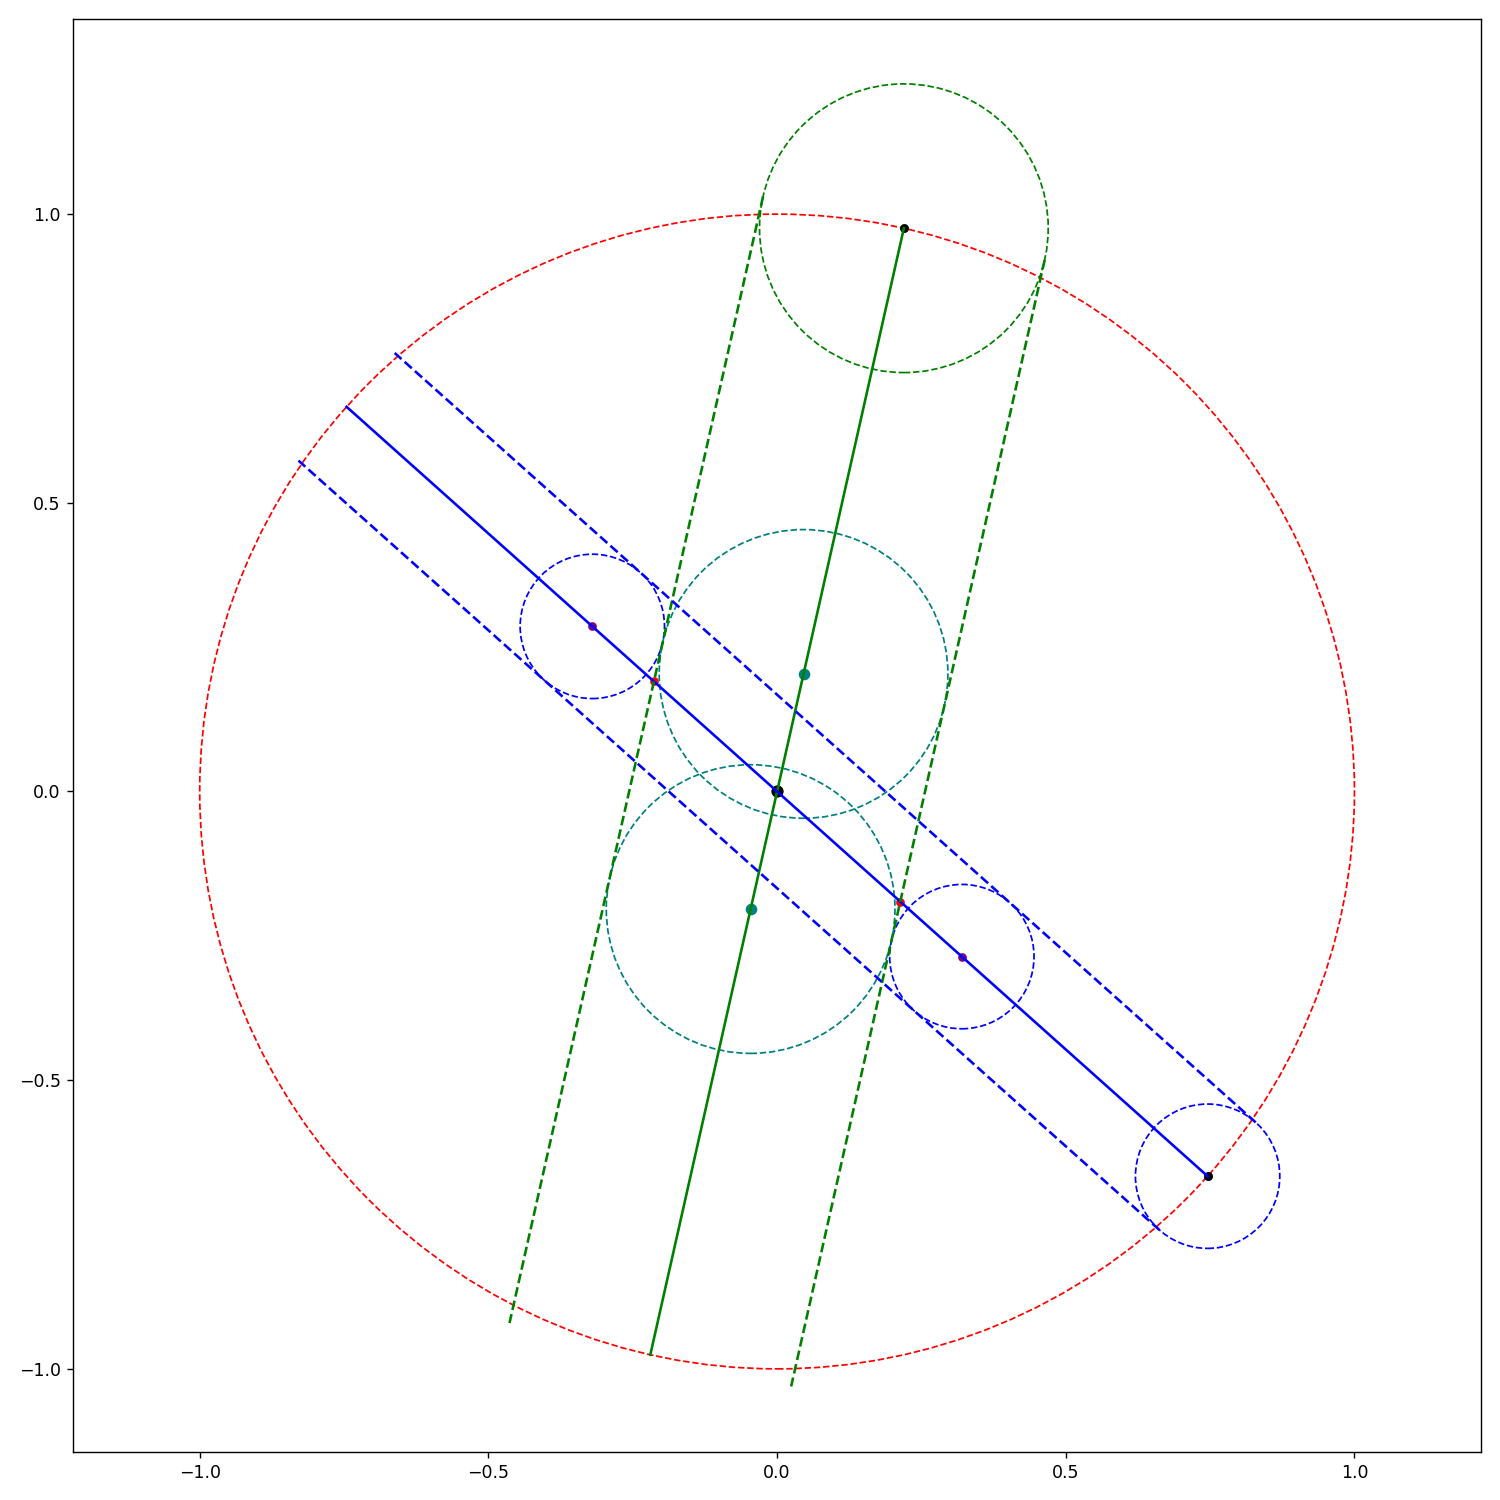

[1.]
[-5.55111512e-17 -2.22044605e-16]
[1.34940723]
---------------
[ 0.32001571 -0.28597029]
orth1 [-0.97559337  0.21958503]
[-0.0458318 -0.2036259]


In [543]:





# axis[0,0].scatter(shifted1[0], shifted1[1], c = 'purple', s = 16)
# axis[0,0].scatter(shifted2[0], shifted2[1], c = 'purple', s = 16)

line1 = lambda x: p1[:] + x * -dir1[:]
line2 = lambda x: p2[:] + x * -dir2[:]

l1 = line1(np.linspace(0,2,256))
l2 = line2(np.linspace(0,2,256))

# print(l1.shape)


il = [p2[0] - dir2[0] * intersect2[0], p2[1] - dir2[1] * intersect2[0]]
iFirst = np.array([p2[0] - dir2[0] * (intersect2[0] - a), p2[1] - dir2[1] * (intersect2[0] - a)])[:,0,0]
print('iFirst', iFirst)
iSecond = np.array([p2[0] - dir2[0] * (intersect2[1] + a), p2[1] - dir2[1] * (intersect2[1] + a)])[:,0,0]

def plot(fig, axis):
    axis[0,0].cla()
    circle1 = plt.Circle((0, 0), r, color='r',ls='--', fill=False)
    circle2 = plt.Circle((p1[0], p1[1]), r1, color='green',ls='--', fill=False)
    circle3 = plt.Circle((p2[0], p2[1]), r2, color='blue',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    axis[0,0].add_patch(circle2)
    axis[0,0].add_patch(circle3)

    axis[0,0].set_xlim(-1.5, 1.5)
    axis[0,0].set_ylim(-1.5, 1.5)
    axis[0,0].axis('equal')

    axis[0,0].scatter(p1[0], p1[1], c = 'green', s = 16)
    axis[0,0].scatter(p2[0], p2[1], c = 'blue', s = 16)

    axis[0,0].scatter(x1[0], x1[1], c = 'black', s = 16)
    axis[0,0].scatter(x2[0], x2[1], c = 'black', s = 16)

    axis[0,0].plot(l1[0,:], l1[1,:], c = 'green')
    axis[0,0].plot(l2[0,:], l2[1,:], c = 'blue')

    axis[0,0].plot(l1[0,:] + orth1[0,0] * r1 , l1[1,:] + orth1[1,0] * r1, c = 'green',ls='--')
    axis[0,0].plot(l1[0,:] - orth1[0,0] * r1 , l1[1,:] - orth1[1,0] * r1, c = 'green',ls='--')

    axis[0,0].plot(l2[0,:] + orth2[0,0] * r2 , l2[1,:] + orth2[1,0] * r2, c = 'blue',ls='--')
    axis[0,0].plot(l2[0,:] - orth2[0,0] * r2 , l2[1,:] - orth2[1,0] * r2, c = 'blue',ls='--')

    axis[0,0].scatter(0,0,c='red', s = 32)


    axis[0,0].scatter(il[0],il[1], c = 'red', s = 16)
    axis[0,0].scatter(p2[0] - dir2[0] * intersect2[1], p2[1] - dir2[1] * intersect2[1], c = 'red', s = 16)

    axis[0,0].scatter(iFirst[0],iFirst[1], c = 'purple', s = 16)
    circle1 = plt.Circle((iFirst[0], iFirst[1]), r2, color='blue',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    axis[0,0].scatter(iSecond[0],iSecond[1], c = 'purple', s = 16)
    circle1 = plt.Circle((iSecond[0], iSecond[1]), r2, color='blue',ls='--', fill=False)
    axis[0,0].add_patch(circle1)


    axis[0,0].scatter(ip1[0], ip1[1], c = 'black')
    

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)


plot(fig,axis)
fig.tight_layout()

print(i1)
print(ip1)
print(theta1)
print('---------------')
print(iFirst)
print('orth1', orth1[:,0])
o2 = iSecond - orth1[:,0] * (r1 + r2)
o1 = iFirst + orth1[:,0] * (r1 + r2)
print(o1)
axis[0,0].scatter(o1[0],o1[1], c = 'teal', s = 32)
circle1 = plt.Circle((o1[0], o1[1]), r1, color='teal',ls='--', fill=False)
axis[0,0].add_patch(circle1)
axis[0,0].scatter(o2[0],o2[1], c = 'teal', s = 32)
circle1 = plt.Circle((o2[0], o2[1]), r1, color='teal',ls='--', fill=False)
axis[0,0].add_patch(circle1)


In [544]:
print(o2 - p1[:,0])
print(p1[:,0])
print(intersect2)

[-0.17375323 -0.77196747]
[0.21958503 0.97559337]
[0.7138849794372509, 1.286115020562749]


In [23]:

def plot(fig, axis):
    axis[0,0].cla()
    circle1 = plt.Circle((0, 0), r, color='r',ls='--', fill=False)
    circle2 = plt.Circle((p1[0], p1[1]), r1, color='green',ls='--', fill=False)
    circle3 = plt.Circle((p2[0], p2[1]), r2, color='blue',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    axis[0,0].add_patch(circle2)
    axis[0,0].add_patch(circle3)
    
    line1 = lambda x: p1[:] + x * -dir1[:]
    line2 = lambda x: p2[:] + x * -dir2[:]

    l1 = line1(np.linspace(0,2,256))
    l2 = line2(np.linspace(0,2,256))


    axis[0,0].set_xlim(-1.5, 1.5)
    axis[0,0].set_ylim(-1.5, 1.5)
    axis[0,0].axis('equal')

    axis[0,0].scatter(p1[0], p1[1], c = 'green', s = 16)
    axis[0,0].scatter(p2[0], p2[1], c = 'blue', s = 16)

    axis[0,0].scatter(x1[0], x1[1], c = 'black', s = 16)
    axis[0,0].scatter(x2[0], x2[1], c = 'black', s = 16)

    axis[0,0].plot(l1[0,:], l1[1,:], c = 'green')
    axis[0,0].plot(l2[0,:], l2[1,:], c = 'blue')

    axis[0,0].plot(l1[0,:] + orth1[0,0] * r1 , l1[1,:] + orth1[1,0] * r1, c = 'green',ls='--')
    axis[0,0].plot(l1[0,:] - orth1[0,0] * r1 , l1[1,:] - orth1[1,0] * r1, c = 'green',ls='--')

    axis[0,0].plot(l2[0,:] + orth2[0,0] * r2 , l2[1,:] + orth2[1,0] * r2, c = 'blue',ls='--')
    axis[0,0].plot(l2[0,:] - orth2[0,0] * r2 , l2[1,:] - orth2[1,0] * r2, c = 'blue',ls='--')

    axis[0,0].scatter(0,0,c='red', s = 32)

    def intersect(p1, dir1, p2, dir2):
        x  = (-p2[0] + (-p1[1]  + p2[1]) /  dir2[1] * dir2[0] + p1[0]) / (dir1[0] - dir1[1] /  dir2[1] * dir2[0])
        return x, (p1 - dir1 * x)[:,0]


    intersect1 = sorted([intersect(p1, dir1, p2 + orth2 * r2, dir2)[0][0], intersect(p1, dir1, p2 - orth2 * r2, dir2)[0][0]])
    intersect2 = sorted([intersect(p2, dir2, p1 + orth1 * r1, dir1)[0][0], intersect(p2, dir2, p1 - orth1 * r1, dir1)[0][0]])

    il = [p2[0] - dir2[0] * intersect2[0], p2[1] - dir2[1] * intersect2[0]]
    alpha = np.arccos(dir1.T@dir2)
    
    a = r2 / np.sin(alpha)
    a2 = r1 / np.sin(alpha)
    iFirst = np.array([p2[0] - dir2[0] * (intersect2[0] - a), p2[1] - dir2[1] * (intersect2[0] - a)])[:,0,0]
#     print('iFirst', iFirst)
    iSecond = np.array([p2[0] - dir2[0] * (intersect2[1] + a), p2[1] - dir2[1] * (intersect2[1] + a)])[:,0,0]

    axis[0,0].scatter(il[0],il[1], c = 'red', s = 16)
    axis[0,0].scatter(p2[0] - dir2[0] * intersect2[1], p2[1] - dir2[1] * intersect2[1], c = 'red', s = 16)

    axis[0,0].scatter(iFirst[0],iFirst[1], c = 'purple', s = 16)
    circle1 = plt.Circle((iFirst[0], iFirst[1]), r2, color='blue',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    axis[0,0].scatter(iSecond[0],iSecond[1], c = 'purple', s = 16)
    circle1 = plt.Circle((iSecond[0], iSecond[1]), r2, color='blue',ls='--', fill=False)
    axis[0,0].add_patch(circle1)


    axis[0,0].scatter(ip1[0], ip1[1], c = 'black')
    
def getIntersectionPoint(p1, dir1, vel1, p2, dir2, vel2, x):
    alpha = np.arccos(dir1.T@dir2)
    a = r2 / np.sin(alpha)
    a2 = r1 / np.sin(alpha)
#     print('alpha:', alpha)
    
    i1 = np.array(p2[:,0] - x * dir2[:,0])
#     print('i1', i1)
    b = np.linalg.norm(-i1)
    b1 = np.linalg.norm(p2[:,0])
    b2 = np.linalg.norm(i1 - p2[:,0])
    s = -1 if b2 > b1 else 1
    
#     print('b', b)
#     print('b1', b1, 'b2', b2, 's', s)
    b = b * s
    beta = np.arcsin(np.sin(alpha) / (r1 + r2) * b) if np.abs(np.sin(alpha) / (r1 + r2) * b) < 1 else np.pi/2 - 0.01
#     print('beta', beta, 'np.sin(alpha) / (r1 + r2) * b', np.sin(alpha) / (r1 + r2) * b)
    gamma = np.pi - beta - alpha
#     print('gamma', gamma)

    c = (np.sin(gamma) / np.sin(beta) * b)[0][0]
    res = (np.linalg.norm(- p1[:,0]) - c)
    i2 = np.array(p1[:,0] - (res) * dir1[:,0])
    
#     dt = 0.1
    
    return i1, i2, res 
    

<IPython.core.display.Javascript object>


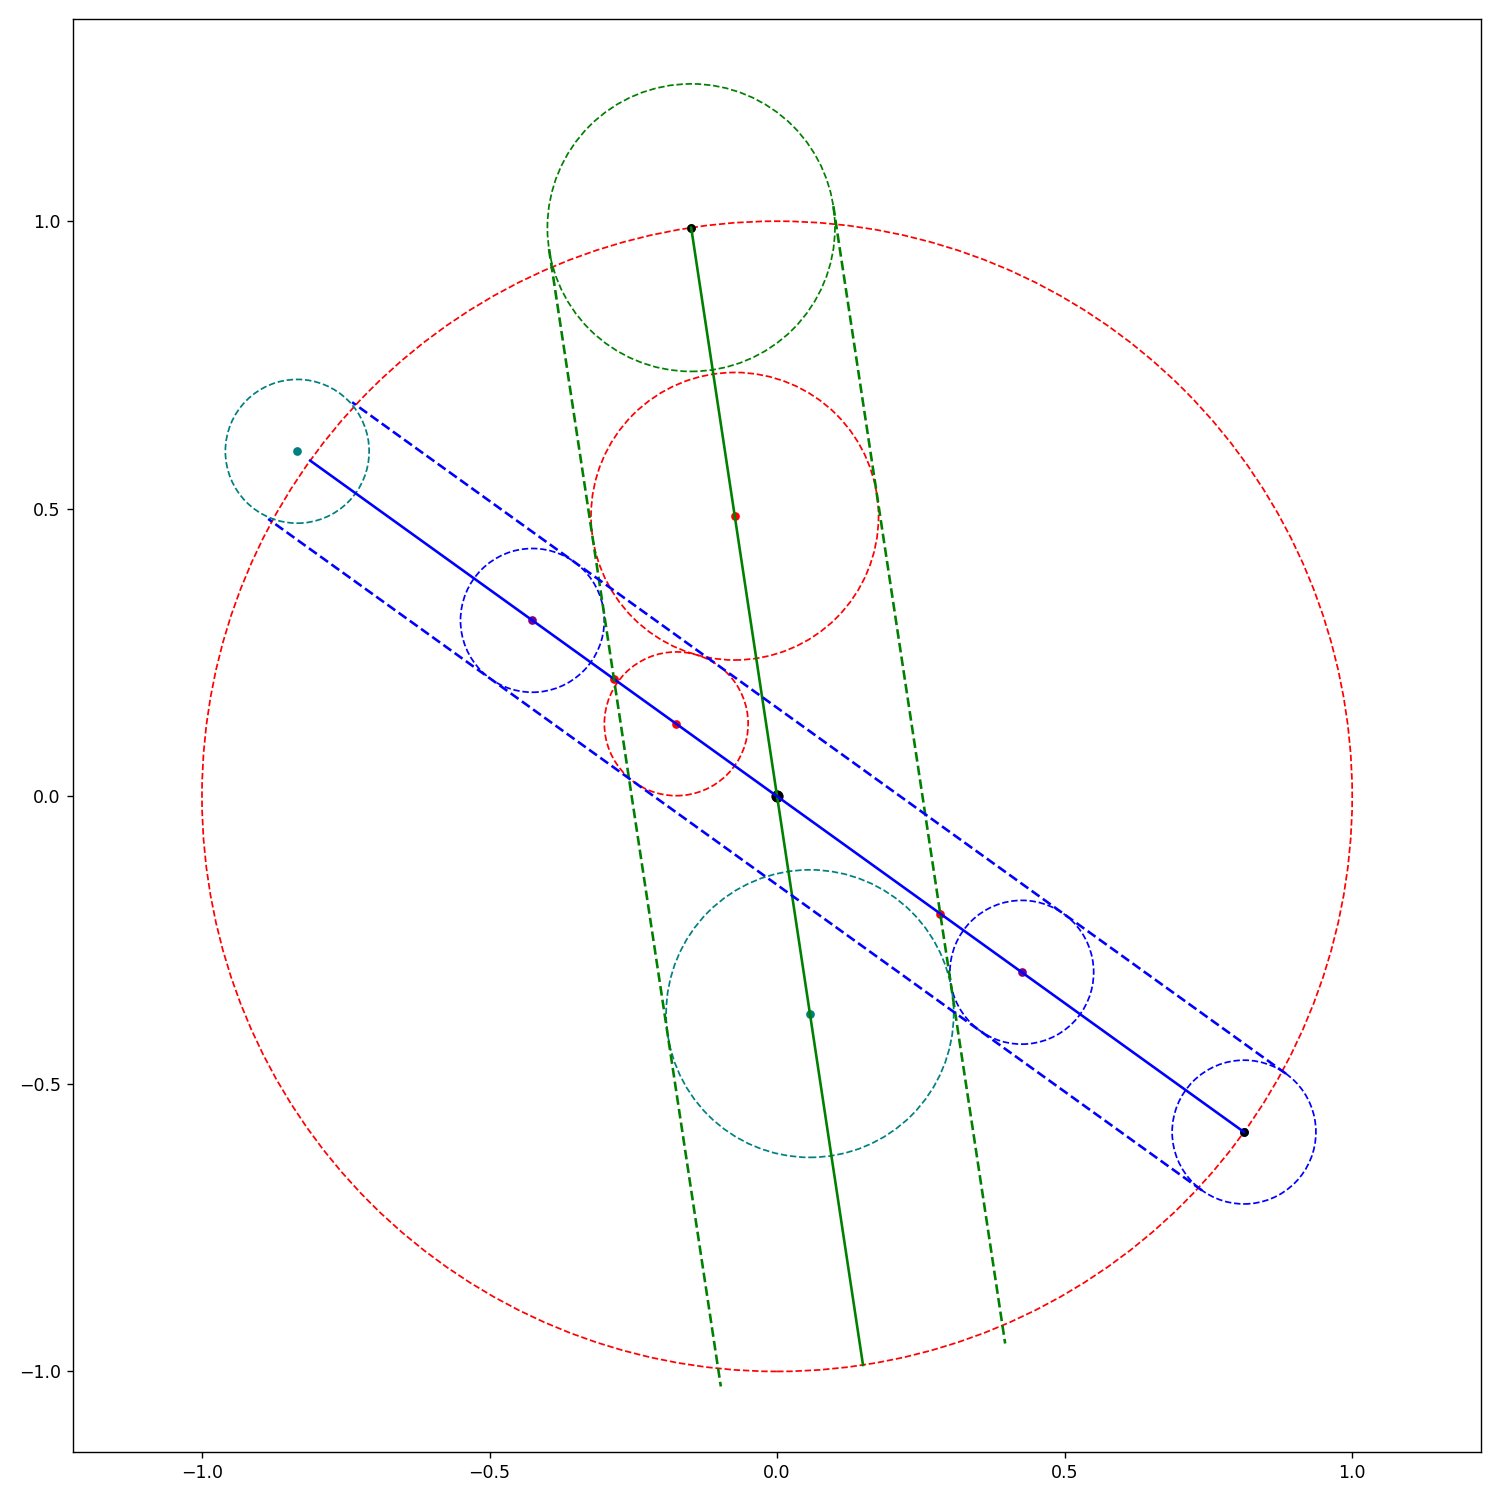

interactive(children=(FloatSlider(value=0.4759577051839889, description='x', max=1.5240422948160108, min=0.475…

In [24]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)


plot(fig,axis)
fig.tight_layout()

def f(x, y):
    plot(fig,axis)
    i1, i2, res = getIntersectionPoint(p1, dir1, vel1, p2, dir2, vel2, x)
#     iFirst = [p2[0] - dir2[0] * x, p2[1] - dir2[1] * x]
#     axis[0,0].scatter(iFirst[0],iFirst[1], c = 'purple', s = 16)
#     circle1 = plt.Circle((iFirst[0], iFirst[1]), r2, color='blue',ls='--', fill=False)
#     axis[0,0].add_patch(circle1)
    
#     iFirst = [p1[0] - dir1[0] * y, p1[1] - dir1[1] * y]
    
#     alpha = np.arccos(dir1.T@dir2)
#     print('alpha:', alpha)
    
#     i1 = np.array(p2[:,0] - x * dir2[:,0])
#     print('i1', i1)
#     b = np.linalg.norm(-i1)
#     b1 = np.linalg.norm(p2[:,0])
#     b2 = np.linalg.norm(i1 - p2[:,0])
#     s = -1 if b2 > b1 else 1
    
# #     print('b', b)
# #     print('b1', b1, 'b2', b2, 's', s)
#     b = b * s
#     beta = np.arcsin(np.sin(alpha) / (r1 + r2) * b) if np.abs(np.sin(alpha) / (r1 + r2) * b) < 1 else np.pi/2 - 0.01
# #     print('beta', beta, 'np.sin(alpha) / (r1 + r2) * b', np.sin(alpha) / (r1 + r2) * b)
#     gamma = np.pi - beta - alpha
# #     print('gamma', gamma)

#     c = (np.sin(gamma) / np.sin(beta) * b)[0][0]
#     res = (np.linalg.norm(- p1[:,0]) - c)
#     i2 = np.array(p1[:,0] - (res) * dir1[:,0])
    
    axis[0,0].scatter(i1[0],i1[1], c = 'red', s = 16)
    circle1 = plt.Circle((i1[0], i1[1]), r2, color='red',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    axis[0,0].scatter(i2[0],i2[1], c = 'red', s = 16)
    circle1 = plt.Circle((i2[0], i2[1]), r1, color='red',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    
    dt = 0.1
    is1 = np.array(p2[:,0] - (x - dt * vel2) * dir2[:,0] - y * dir2[:,0] * vel2)
    is2 = np.array(p1[:,0] - (res - dt * vel1) * dir1[:,0] - y * dir1[:,0] * vel1)
    
    axis[0,0].scatter(is1[0],is1[1], c = 'teal', s = 16)
    circle1 = plt.Circle((is1[0], is1[1]), r2, color='teal',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    axis[0,0].scatter(is2[0],is2[1], c = 'teal', s = 16)
    circle1 = plt.Circle((is2[0], is2[1]), r1, color='teal',ls='--', fill=False)
    axis[0,0].add_patch(circle1)
    
    
    return x

intersect1 = sorted([intersect(p1, dir1, p2 + orth2 * r2, dir2)[0][0], intersect(p1, dir1, p2 - orth2 * r2, dir2)[0][0]])
intersect2 = sorted([intersect(p2, dir2, p1 + orth1 * r1, dir1)[0][0], intersect(p2, dir2, p1 - orth1 * r1, dir1)[0][0]])
alpha = np.arccos(dir1.T@dir2)
a = r2 / np.sin(alpha)
interact(f, x=widgets.FloatSlider(min = intersect2[0] - a, max = intersect2[1] + a, value = intersect2[0] - a, step = 0.01), y = widgets.FloatSlider(min = 0, max = 1, value = 0, step = 0.01));

<IPython.core.display.Javascript object>


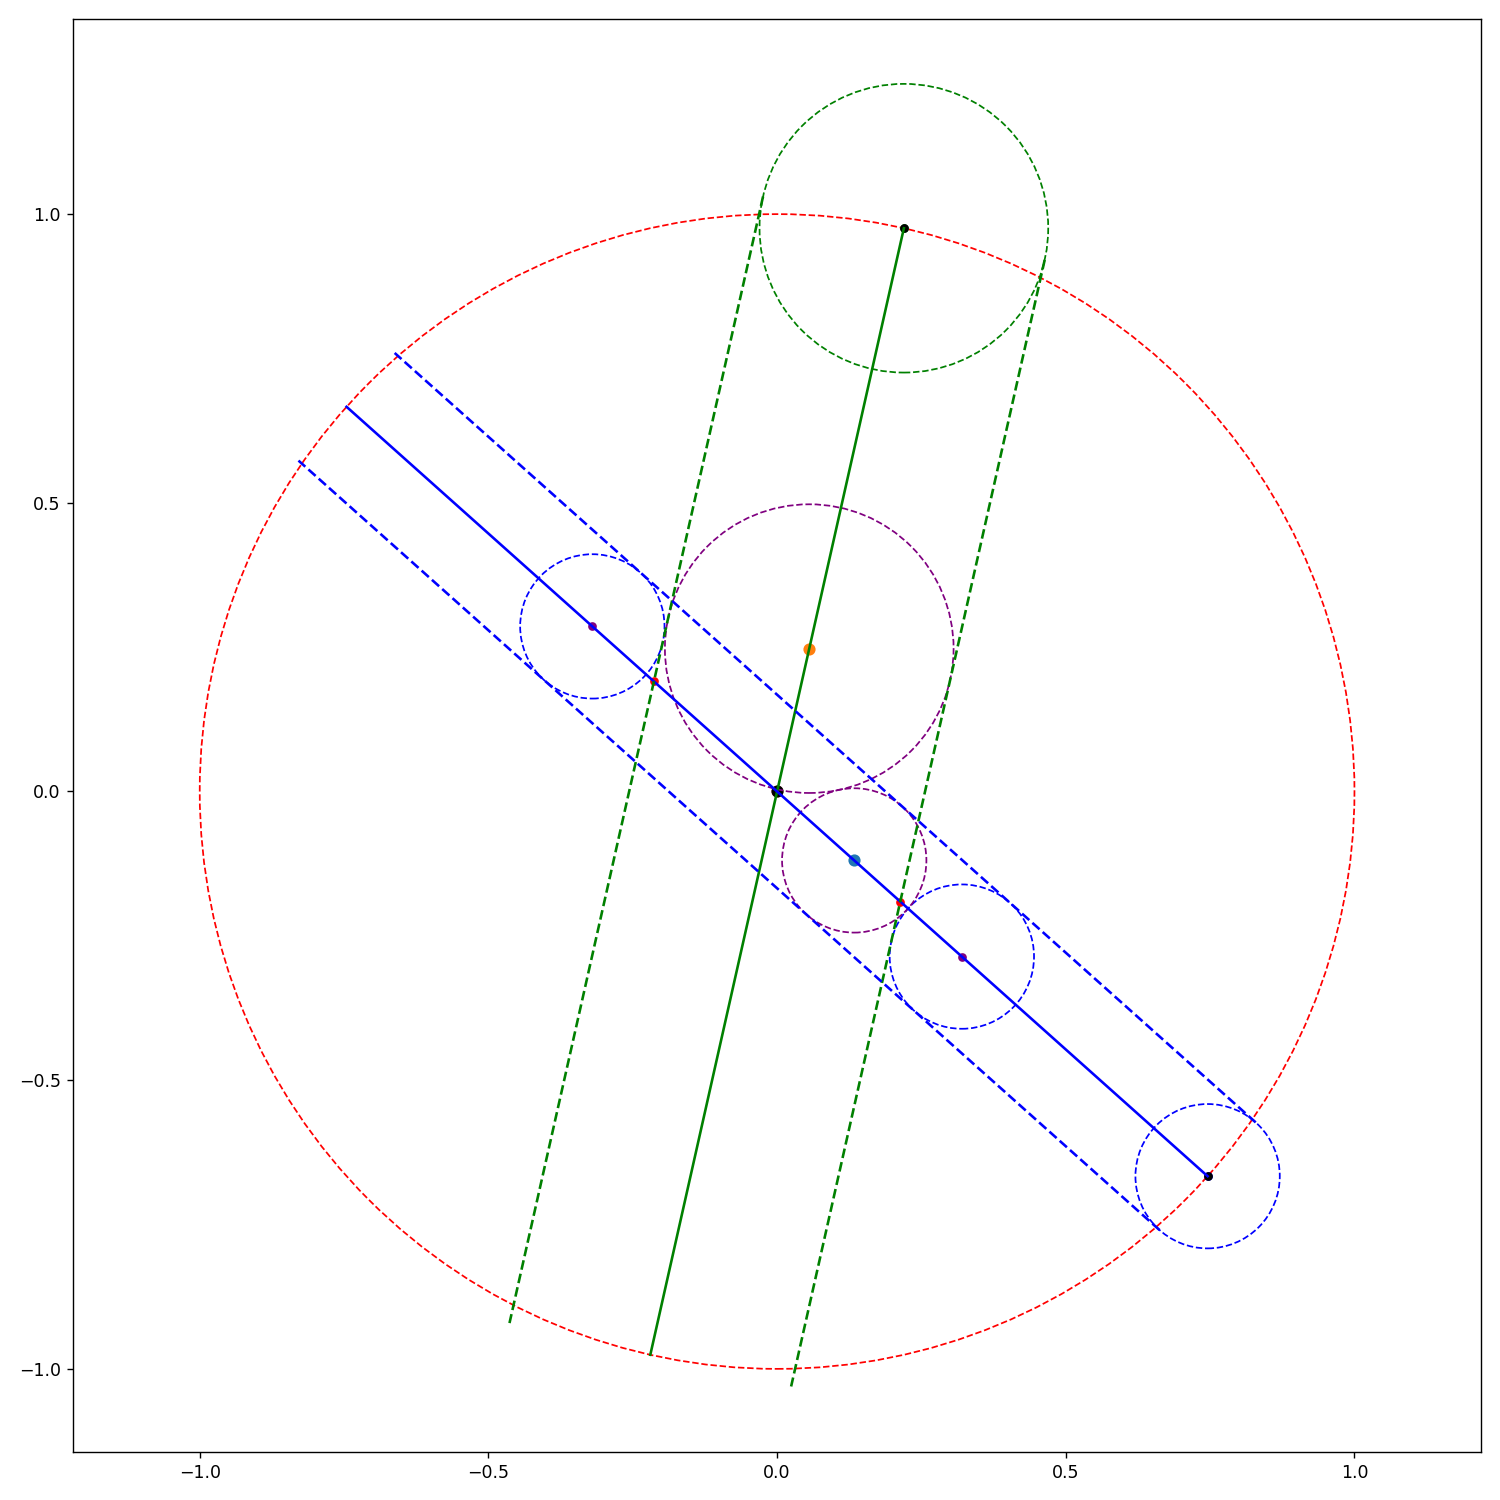

0.25361943840408163


In [581]:
alpha = np.arccos(dir1.T@dir2)
l = ((intersect2[0] - a + intersect2[1] + a) / 2 * 0.25 + intersect2[0] - a )[0][0]

alpha = np.arccos(dir1.T@dir2)
i1 = np.array(p2[:,0] - x * dir2[:,0])
b = np.linalg.norm(-i1)
beta = np.arcsin(np.sin(alpha) / (r1 + r2) * b)
gamma = np.pi - beta - alpha

c = (np.sin(gamma) / np.sin(beta) * b)[0][0]
i2 = np.array(p1[:,0] - (np.linalg.norm(- p1[:,0]) - c) * dir1[:,0])

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)


plot(fig,axis)
fig.tight_layout()

axis[0,0].scatter(i1[0],i1[1])
circle1 = plt.Circle((i1[0], i1[1]), r2, color='purple',ls='--', fill=False)
axis[0,0].add_patch(circle1)

print(c)


axis[0,0].scatter(i2[0],i2[1])
circle1 = plt.Circle((i2[0], i2[1]), r1, color='purple',ls='--', fill=False)
axis[0,0].add_patch(circle1)

# print(beta)


In [574]:
ips

array([-0.09593507, -0.06485629])

In [575]:
p1[:,0]

array([0.21958503, 0.97559337])

In [576]:
ips - p1[:,0]

array([-0.31552009, -1.04044966])

In [531]:
np.linalg.norm(o2-p1)

1.220997632637259

In [126]:
def intersect(p1, dir1, p2, dir2):
    x  = (-p2[0] + (-p1[1]  + p2[1]) /  dir2[1] * dir2[0] + p1[0]) / (dir1[0] - dir1[1] /  dir2[1] * dir2[0])
    return x, (p1 - dir1 * x)[:,0]


def getPositions(r = 1, r1 = 0.125, r2 = 0.125):
    theta1 = np.random.rand(1) * np.pi * 2
    # theta2 = np.random.rand(1) * np.pi * 1.5 + theta1
    theta2 = theta1 + np.pi + np.random.normal(0,np.pi/4)
    offset1 = np.random.normal(0,0.5)
    offset2 = np.random.normal(0,0.5)
    # print(offset1)
    vel1 = np.random.normal(1,0.125)
    vel2 = np.random.normal(1,0.125)
    # print(vel1, vel2)

    p1 = np.array([np.cos(theta1) * r, np.sin(theta1) * r])
    p2 = np.array([np.cos(theta2) * r, np.sin(theta2) * r])
    x1 = np.array([np.cos(theta1) * r, np.sin(theta1) * r])
    x2 = np.array([np.cos(theta2) * r, np.sin(theta2) * r])

    dir1 = p1 / np.linalg.norm(p1)
    dir2 = p2 / np.linalg.norm(p2)
    orth1 = np.array([-dir1[1],dir1[0]]) / np.linalg.norm(dir1)
    orth2 = np.array([-dir2[1],dir2[0]]) / np.linalg.norm(dir2)

    p1 = p1 + orth1 * offset1 * r1
    p2 = p2 + orth2 * offset2 * r2

    i1, ip1 = intersect(p1, dir1, p2, dir2)
    # print(p1[:,0], np.linalg.norm(p1))
    # print(ip1, np.linalg.norm(ip1))

    dist1 = np.linalg.norm(ip1 - p1[:,0])
    dist2 = np.linalg.norm(ip1 - p2[:,0])
    # print(dist1, dist2)

    shifted1 = p1 - dir1 * (dist1 - vel1)
    shifted2 = p2 - dir2 * (dist2 - vel2)

    intersect21 = sorted([intersect(shifted1 + orth1 * offset1 * r1, dir1, shifted2, dir2)[0][0], intersect(shifted1 - orth1 * offset1 * r1, dir1, shifted2, dir2)[0][0]])
    # print(intersect21)
    # print(intersect21[0]/vel1)
    # print(intersect21[1]/vel1)

    offset = np.random.rand() * (intersect21[1]/vel1 - intersect21[0]/vel1) + intersect21[0]/vel1
    # print(offset)

    dist1 = np.linalg.norm(ip1 - p1[:,0])
    shifted1 = p1 - dir1 * (dist1 - offset)

    i,ip = intersect(shifted1, dir1, shifted2, dir2)
    
    return shifted1, dir1, orth1, vel1, shifted2, dir2, orth2, vel2, ip

p1, dir1, orth1, vel1, p2, dir2, orth2, vel2, ip = getPositions(1, 0.125, 0.125)

In [289]:

p1, dir1, orth1, vel1, p2, dir2, orth2, vel2, ip = getPositions(1, 0.125, 0.125)

r = 0.25
offset1 = np.random.rand()
i11, ip11 = intersect(p1 + orth1 * r, dir1, p2 + orth2 * r, dir2)
i12, ip12 = intersect(p1 + orth1 * r, dir1, p2 - orth2 * r, dir2)
i21, ip21 = intersect(p1 - orth1 * r, dir1, p2 + orth2 * r, dir2)
i22, ip22 = intersect(p1 - orth1 * r, dir1, p2 - orth2 * r, dir2)

s, ips = intersect(p1, dir1, p2, dir2)
d1 = np.linalg.norm(ips - p1[:,0])
d2 = np.linalg.norm(ips - p2[:,0])
print(ips, d1, d2)

# s = r / vel2

t1 = (d1 - r) / vel1, (d1 + r) / vel1
t2 = (d2 - r) / vel2, (d2 + r) / vel2
ip1 = [p1[0] - t1[0] * dir1[0,0] * vel1 + dir1[0,0] * r * offset1 / vel1, p1[1] - t1[0] * dir1[1,0] * vel1 + dir1[1,0] * r * offset1 / vel1]
ip2 = [p2[0] - t2[0] * dir2[0,0] * vel2 + dir2[0,0] * r / vel2, p2[1] - t2[0] * dir2[1,0] * vel2 + dir2[1,0] * r / vel2]


In [379]:
print(ips)
print(p1[:,0])

[0.01703199 0.10202762]
[0.95328628 0.42062555]


In [377]:
ips - p1

array([[-0.93625429, -0.85125866],
       [-0.40359356, -0.31859793]])

In [380]:
i11, ip11 = intersect(p1 + orth1 * r, dir1, p2 + orth2 * r, dir2)
i12, ip12 = intersect(p1 + orth1 * r, dir1, p2 - orth2 * r, dir2)
i21, ip21 = intersect(p1 - orth1 * r, dir1, p2 + orth2 * r, dir2)
i22, ip22 = intersect(p1 - orth1 * r, dir1, p2 - orth2 * r, dir2)

s, ips = intersect(p1, dir1, p2, dir2)
d1 = np.linalg.norm(ips - p1[:,0])
d2 = np.linalg.norm(ips - p2[:,0])
print(ips, d1, d2)

# s = r / vel2

t1 = (d1 - r) / vel1, (d1 + r) / vel1
t2 = (d2 - r) / vel2, (d2 + r) / vel2
ip1 = [p1[0] - t1[0] * dir1[0,0] * vel1 + dir1[0,0] * r * offset1 / vel1, p1[1] - t1[0] * dir1[1,0] * vel1 + dir1[1,0] * r * offset1 / vel1]
ip2 = [p2[0] - t2[0] * dir2[0,0] * vel2 + dir2[0,0] * r / vel2, p2[1] - t2[0] * dir2[1,0] * vel2 + dir2[1,0] * r / vel2]

print(t1,t2)
# print()
# shifted1[:,0]

print(i11, i12, i21, i22)

n1 = sorted([i11,i12])[0] - 0.125 * 2.75

# i21, ip21 = intersect(p2, dir2, p1, dir1)
# i22, ip22 = intersect(p2, dir2, p1, dir1)
n2 = sorted([i21,i22])[0] - 0.125 * 2.75

[0.01703199 0.10202762] 0.9889776229864742 1.1246030523625163
(0.7445406659671561, 1.248304679116972) (0.7776993406919792, 1.2223006593080208)
[0.65923294] [1.17851821] [0.79943704] [1.3187223]


<IPython.core.display.Javascript object>


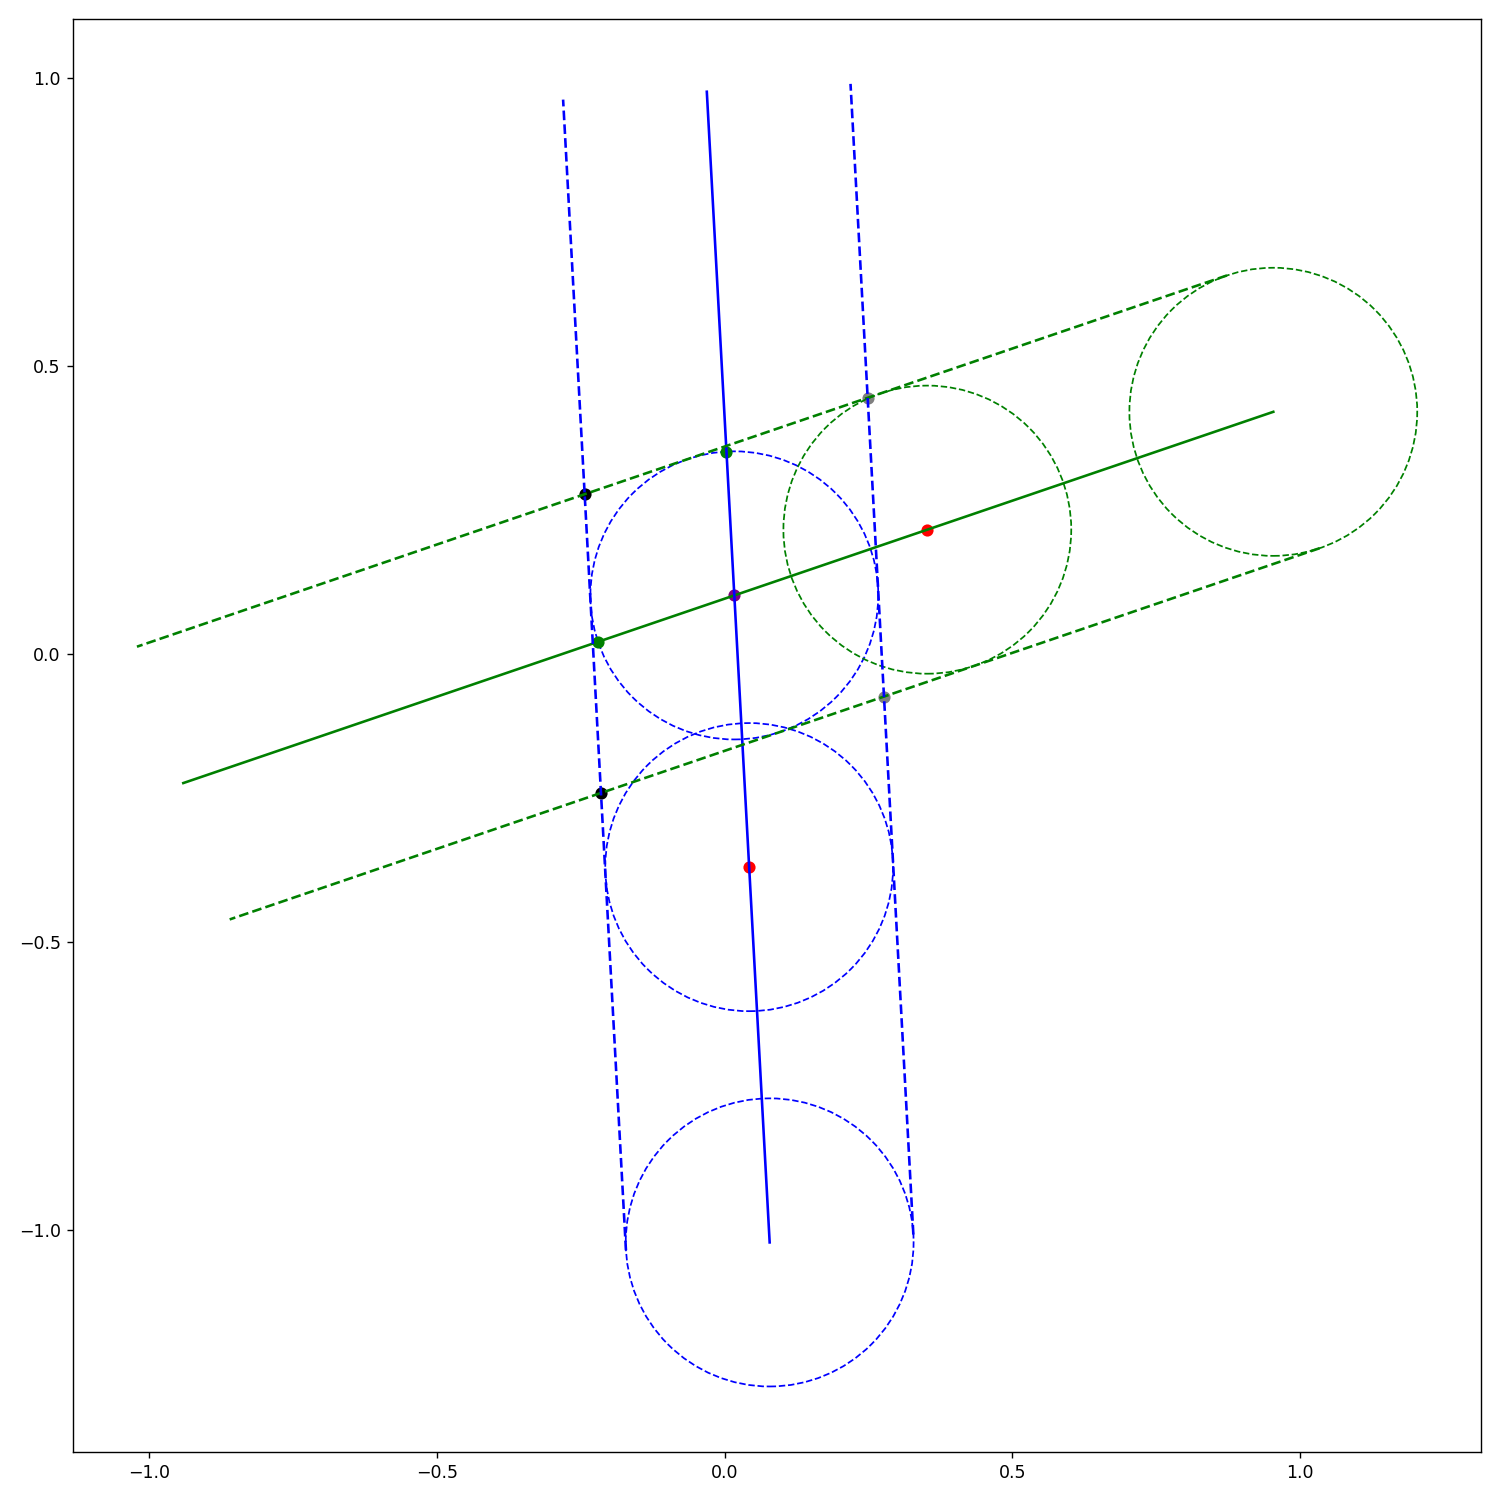

In [391]:
fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)

line1 = lambda x: p1[:] + x * -dir1[:]
line2 = lambda x: p2[:] + x * -dir2[:]

l1 = line1(np.linspace(0,2,256))
l2 = line2(np.linspace(0,2,256))

# print(l1.shape)

axis[0,0].plot(l1[0,:], l1[1,:], c = 'green')
axis[0,0].plot(l2[0,:], l2[1,:], c = 'blue')

axis[0,0].plot(l1[0,:] + orth1[0,0] * r , l1[1,:] + orth1[1,0] * r, c = 'green',ls='--')
axis[0,0].plot(l1[0,:] - orth1[0,0] * r , l1[1,:] - orth1[1,0] * r, c = 'green',ls='--')

axis[0,0].plot(l2[0,:] + orth2[0,0] * r , l2[1,:] + orth2[1,0] * r, c = 'blue',ls='--')
axis[0,0].plot(l2[0,:] - orth2[0,0] * r , l2[1,:] - orth2[1,0] * r, c = 'blue',ls='--')

axis[0,0].scatter(ip11[0], ip11[1], c = 'grey')
axis[0,0].scatter(ip12[0], ip12[1], c = 'black')
axis[0,0].scatter(ip21[0], ip21[1], c = 'grey')
axis[0,0].scatter(ip22[0], ip22[1], c = 'black')

axis[0,0].scatter(ips[0], ips[1], c = 'purple')

circle2 = plt.Circle((p1[0], p1[1]), r, color='green',ls='--', fill=False)
circle3 = plt.Circle((p2[0], p2[1]), r, color='blue',ls='--', fill=False)
axis[0,0].add_patch(circle2)
axis[0,0].add_patch(circle3)

circle3 = plt.Circle((ips[0], ips[1]), r, color='blue',ls='--', fill=False)
axis[0,0].add_patch(circle3)

axis[0,0].scatter(ip1[0], ip1[1], c = 'red')
axis[0,0].scatter(ip2[0], ip2[1], c = 'red')
circle2 = plt.Circle((ip1[0], ip1[1]), r, color='green',ls='--', fill=False)
circle3 = plt.Circle((ip2[0], ip2[1]), r, color='blue',ls='--', fill=False)
axis[0,0].add_patch(circle2)
axis[0,0].add_patch(circle3)

axis[0,0].scatter(p1[0] - t1[1] * dir1[0,0] * vel1, p1[1] - t1[1] * dir1[1,0] * vel1, c = 'green')
axis[0,0].scatter(p2[0] - t2[1] * dir2[0,0] * vel2, p2[1] - t2[1] * dir2[1,0] * vel2, c = 'green')

fig.tight_layout()


In [355]:
dir1[1,0]

0.3221487728231171

In [270]:
shifted1 = p1 - n1 * dir1
shifted2 = p2 - n2 * dir2

In [271]:
s, ips = intersect(shifted1, dir1, shifted2, dir2)
d1 = np.linalg.norm(ips - shifted1[:,0]) / vel1
d2 = np.linalg.norm(ips - shifted2[:,0]) / vel2
print(ips, d1, d2)
# print()
# shifted1[:,0]

[0.01703199 0.10202762] 0.34633775904049857 0.30566340654852847


In [318]:
s = 0.25 / vel2

t1 = (d1 - r) / vel1, (d1 + r) / vel1
t2 = (d2 - r) / vel2, (d1 + r) / vel1
print(s, t1, t2)

shifted2 = ips + t2[1] / vel2 * dir2[:,0]
print(shifted2)
print(dir2[:,0])

0.2223006593080208 (0.09706299222420307, 0.6008270053740191) (0.04949604790027312, 0.6008270053740191)
[ 0.04619391 -0.43143285]
[ 0.05458407 -0.99850918]


<IPython.core.display.Javascript object>


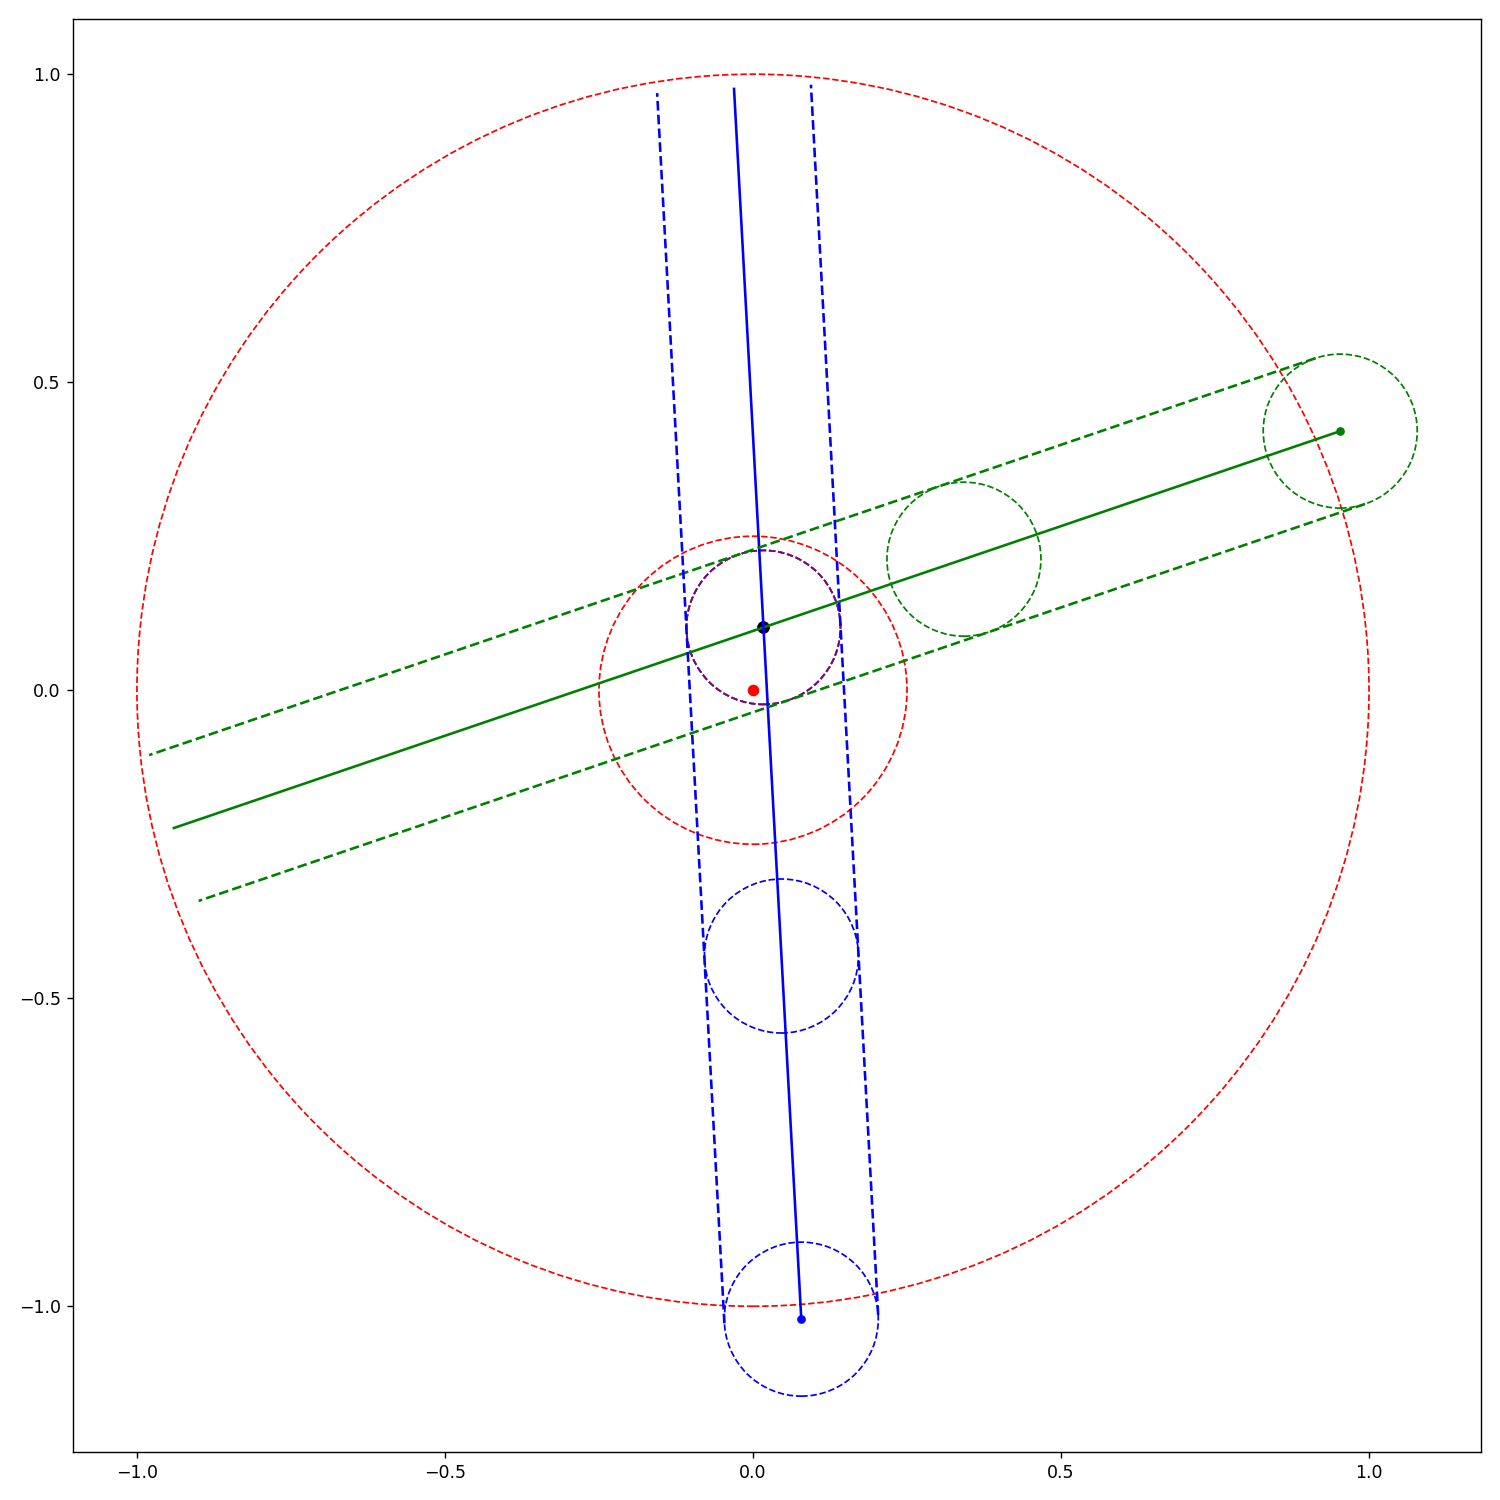

(2, 256)
[0.96230909]
[-0.00045385 -0.06329259]
[5.63814258]


In [319]:
fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)



circle1 = plt.Circle((0, 0), 1, color='r',ls='--', fill=False)
circle2 = plt.Circle((shifted1[0], shifted1[1]), r1, color='green',ls='--', fill=False)
circle3 = plt.Circle((shifted2[0], shifted2[1]), r1, color='blue',ls='--', fill=False)
axis[0,0].add_patch(circle1)
axis[0,0].add_patch(circle2)
axis[0,0].add_patch(circle3)




circle1 = plt.Circle((0, 0), r, color='r',ls='--', fill=False)
circle2 = plt.Circle((p1[0], p1[1]), r1, color='green',ls='--', fill=False)
circle3 = plt.Circle((p2[0], p2[1]), r1, color='blue',ls='--', fill=False)
axis[0,0].add_patch(circle1)
axis[0,0].add_patch(circle2)
axis[0,0].add_patch(circle3)


circle2 = plt.Circle((ip11[0], ip11[1]), r1, color='grey',ls='--', fill=False)
circle3 = plt.Circle((ip12[0], ip12[1]), r1, color='purple',ls='--', fill=False)
axis[0,0].scatter(ip11[0], ip11[1], color = 'grey')
axis[0,0].scatter(ip12[0], ip12[1], color = 'purple')
axis[0,0].add_patch(circle2)
axis[0,0].add_patch(circle3)

circle2 = plt.Circle((ip21[0], ip21[1]), r1, color='grey',ls='--', fill=False)
circle3 = plt.Circle((ip22[0], ip22[1]), r1, color='purple',ls='--', fill=False)
axis[0,0].scatter(ip21[0], ip21[1], color = 'grey')
axis[0,0].scatter(ip22[0], ip22[1], color = 'purple')
axis[0,0].add_patch(circle2)
axis[0,0].add_patch(circle3)

axis[0,0].set_xlim(-1.5, 1.5)
axis[0,0].set_ylim(-1.5, 1.5)
axis[0,0].axis('equal')
fig.tight_layout()

axis[0,0].scatter(p1[0], p1[1], c = 'green', s = 16)
axis[0,0].scatter(p2[0], p2[1], c = 'blue', s = 16)

# axis[0,0].scatter(x1[0], x1[1], c = 'black', s = 16)
# axis[0,0].scatter(x2[0], x2[1], c = 'black', s = 16)
# axis[0,0].scatter(shifted1[0], shifted1[1], c = 'purple', s = 16)
# axis[0,0].scatter(shifted2[0], shifted2[1], c = 'purple', s = 16)

line1 = lambda x: p1[:] + x * -dir1[:]
line2 = lambda x: p2[:] + x * -dir2[:]

l1 = line1(np.linspace(0,2,256))
l2 = line2(np.linspace(0,2,256))

print(l1.shape)

axis[0,0].plot(l1[0,:], l1[1,:], c = 'green')
axis[0,0].plot(l2[0,:], l2[1,:], c = 'blue')

axis[0,0].plot(l1[0,:] + orth1[0,0] * r1 , l1[1,:] + orth1[1,0] * r1, c = 'green',ls='--')
axis[0,0].plot(l1[0,:] - orth1[0,0] * r1 , l1[1,:] - orth1[1,0] * r1, c = 'green',ls='--')

axis[0,0].plot(l2[0,:] + orth2[0,0] * r2 , l2[1,:] + orth2[1,0] * r2, c = 'blue',ls='--')
axis[0,0].plot(l2[0,:] - orth2[0,0] * r2 , l2[1,:] - orth2[1,0] * r2, c = 'blue',ls='--')

axis[0,0].scatter(0,0,c='red', s = 32)


axis[0,0].scatter(ip[0], ip[1], c = 'black')

print(i1)
print(ip1)
print(theta1)



In [321]:
shifted1

array([[0.34245635],
       [0.21276626]])

In [322]:

# def loadConfig(config, i, j):
#     with open(config, 'r') as file:
#         tomlConfig = file.read()
#     parsedConfig = tomli.loads(tomlConfig)
    
#     parsedConfig['emitter']['fluidL']['velocity'] = velocities[i]
#     parsedConfig['emitter']['fluidR']['velocity'] = velocities[j]
#     parsedConfig['export']['prefix'] = 'collision %d x %d' %(i,j)
#     parsedConfig['export']['active'] = False
    
#     simulationScheme = 'deltaSPH'
#     if 'simulation' in parsedConfig:
#         if 'scheme' in parsedConfig['simulation']:
#             simulationScheme = parsedConfig['simulation']['scheme']
            
#     if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
#         return parsedConfig, deltaSPHSimulation
#     if simulationScheme == 'dfsph':
#         return parsedConfig, dfsphSimulation

In [411]:

p1, dir1, orth1, vel1, p2, dir2, orth2, vel2, ip = getPositions(1, 0.125, 0.125)

r = 0.25
offset1 = np.random.rand()
i11, ip11 = intersect(p1 + orth1 * r, dir1, p2 + orth2 * r, dir2)
i12, ip12 = intersect(p1 + orth1 * r, dir1, p2 - orth2 * r, dir2)
i21, ip21 = intersect(p1 - orth1 * r, dir1, p2 + orth2 * r, dir2)
i22, ip22 = intersect(p1 - orth1 * r, dir1, p2 - orth2 * r, dir2)

s, ips = intersect(p1, dir1, p2, dir2)
d1 = np.linalg.norm(ips - p1[:,0])
d2 = np.linalg.norm(ips - p2[:,0])
# print(ips, d1, d2)

# s = r / vel2

t1 = (d1 - r) / vel1, (d1 + r) / vel1
t2 = (d2 - r) / vel2, (d2 + r) / vel2
ip1 = [p1[0] - t1[0] * dir1[0,0] * vel1 + dir1[0,0] * r * offset1 / vel1, p1[1] - t1[0] * dir1[1,0] * vel1 + dir1[1,0] * r * offset1 / vel1]
ip2 = [p2[0] - t2[0] * dir2[0,0] * vel2 + dir2[0,0] * r / vel2, p2[1] - t2[0] * dir2[1,0] * vel2 + dir2[1,0] * r / vel2]


In [412]:
config = 'configs/colgen_deltasph.toml'
with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

parsedConfig['emitter']['fluidL']['min'] = (np.array(ip1)[:,0] - 0.125 * 2).tolist() 
parsedConfig['emitter']['fluidL']['max'] = (np.array(ip1)[:,0] + 0.125 * 2).tolist() 
parsedConfig['emitter']['fluidL']['velocity'] = (-dir1[:,0] * vel1).tolist()

parsedConfig['emitter']['fluidR']['min'] = (np.array(ip2)[:,0] - 0.125 * 2).tolist() 
parsedConfig['emitter']['fluidR']['max'] = (np.array(ip2)[:,0] + 0.125 * 2).tolist() 
parsedConfig['emitter']['fluidR']['velocity'] = (-dir2[:,0] * vel2).tolist()

simulationModel = deltaSPHSimulation

In [413]:
# config = 'configs/dambreak_dfsph.toml'
config = 'configs/colgen_deltasph.toml'
# config = 'configs/collision_dfsph.toml'
# config = 'configs/generative.toml'
# config = 'configs/generative_dfsph.toml'
# config = 'configs/collision2_dfsph.toml'
# config = 'configs/oscillating_drop_deltasph.toml'
# parsedConfig, simulationModel = loadConfig(config,2,2)
# parsedConfig, simulationModel = loadConfig(config)

In [414]:
# parsedConfig['generative']['seed'] = 42

In [415]:
sphSimulation = simulationModel(parsedConfig)

In [416]:
sphSimulation.initializeSimulation()

In [417]:
print(plt.style.available)
# from plotting import *
# plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [418]:
# positions = sphSimulation.simulationState['fluidPosition']
# velocities = sphSimulation.simulationState['fluidVelocity']

# sigma = 1

# velocities[:,0] = sigma * positions[:,0]
# velocities[:,1] = -sigma * positions[:,1]

In [419]:
sphSimulation.config['particle']['support'] / (1.95  * np.sqrt(9.81 * 0.6))

0.007459019688795837

<IPython.core.display.Javascript object>


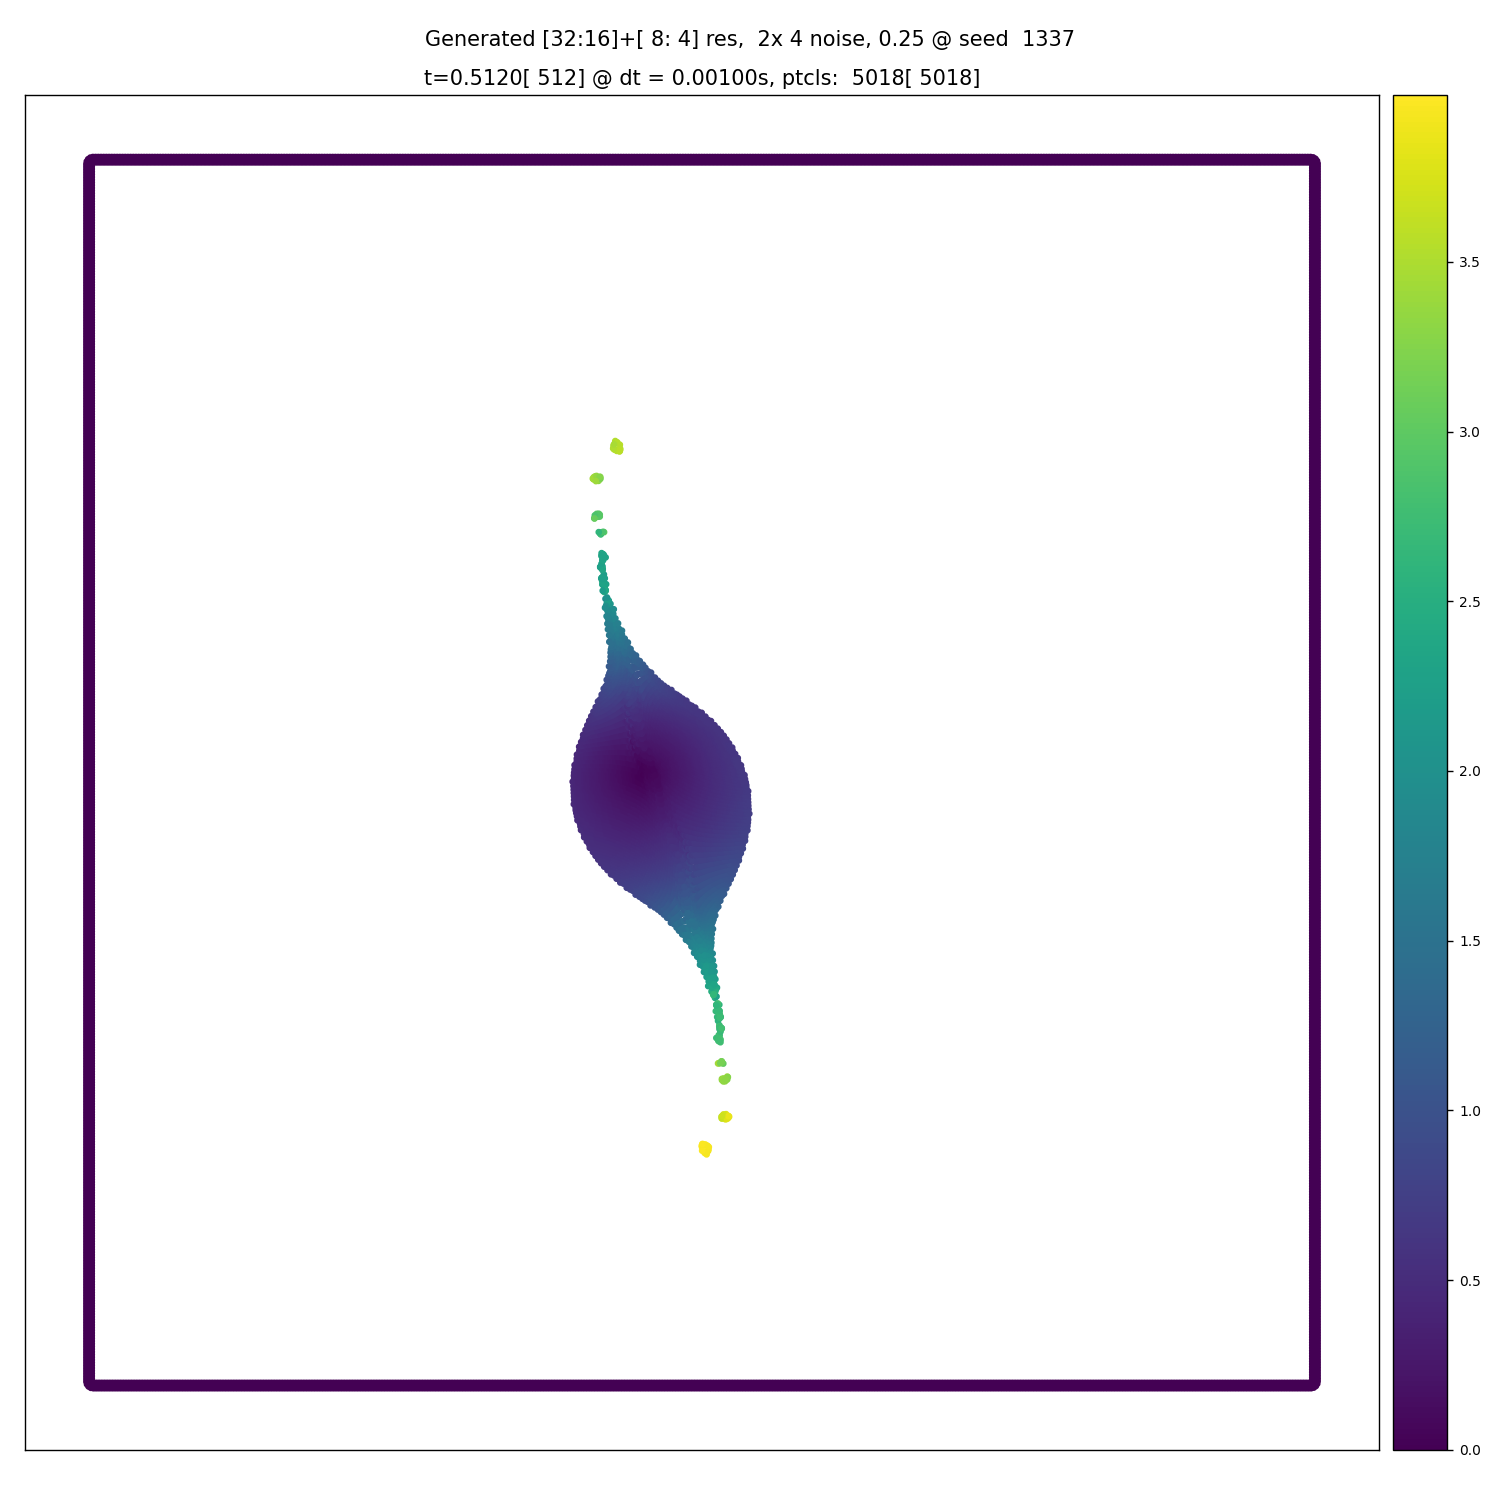

In [420]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = True)
fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()
# data2[:] = 0

data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# data = state['residual'].detach().cpu().numpy()
# data = state['fluidAlpha'].detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

positions = np.vstack((positions, positions2))
data = np.hstack((data, data2))

# positions = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data = sphSimulation.boundaryModule.boundaryVelocity.detach().cpu().numpy() 

# axis[0,0].scatter(positions2[:,0], positions2[:,1], c ='white', s = 4)

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 8)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [421]:
# print(sphSimulation.config['fluid'])

In [422]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './output/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [424]:
timesteps = 256
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 10 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

        positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
        data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy() * 0
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

        positions = np.vstack((positions, positions2))
        data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

  0%|          | 0/256 [00:00<?, ?it/s]

In [151]:
from src.modules.densityDiffusion import computeNormalizationMatrix
from src.kernels import kernel, spikyGrad, kernelGradient
simulationState = sphSimulation.simulationState
normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], simulationState['fluidPosition'], simulationState['fluidVolume'], simulationState['fluidVolume'],\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  sphSimulation.densityDiffusionModule.support, simulationState['fluidDensity'].shape[0], sphSimulation.densityDiffusionModule.eps)     
normalizationMatrix += sphSimulation.boundaryModule.computeNormalizationMatrices(simulationState, sphSimulation)
ni = simulationState['fluidNeighbors'][0]

In [171]:
def gj_solve(m=[1., 0.], n=3, nb=1, result=[0.0, 0.0]):
    r"""A gauss-jordan method to solve an augmented matrix.
    The routine is given the augmented matrix, the number of rows/cols in the
    original matrix and the number of added columns. The result is stored in
    the result array passed.
    Parameters
    ----------
    m : list: a flattened list representing the augmented matrix [A|b].
    n : int: number of columns/rows used from A in augmented_matrix.
    nb: int: number of columns added to A.
    result: list: with size n*nb
    References
    ----------
    https://ricardianambivalence.com/2012/10/20/pure-python-gauss-jordan
    -solve-ax-b-invert-a/
    """

    i, j, eqns, colrange, augCol, col, row, bigrow, nt = 0,0,0,0,0,0,0,0,0
    eqns = n
    colrange = n
    augCol = n + nb
    nt = n + nb

    for col in range(colrange):
        bigrow = col
        for row in range(col + 1, colrange):
            if abs(m[nt*row + col]) > abs(m[nt*bigrow + col]):
                bigrow = row
                temp = m[nt*row + col]
                m[nt*row + col] = m[nt*bigrow + col]
                m[nt*bigrow + col] = temp
    print(m.reshape(4,3))
    rr, rrcol, rb, rbr, kup, kupr, kleft, kleftr = 0,0,0,0,0,0,0,0
    for rrcol in range(0, colrange):
        for rr in range(rrcol + 1, eqns):
            dnr = float(m[nt*rrcol + rrcol])
            if abs(dnr) < 1e-12:
                return 1.0
            cc = -float(m[nt*rr + rrcol]) / dnr
            for j in range(augCol):
                m[nt*rr + j] = m[nt*rr + j] + cc * m[nt*rrcol + j]
    print(m.reshape(4,3))

    backCol, backColr = 0,0
    tol = 1.0e-12
    for rbr in range(eqns):
        rb = eqns - rbr - 1
        if (m[nt*rb + rb] == 0):
            if abs(m[nt*rb + augCol - 1]) > tol:
                # Error, singular matrix.
                return 1.0
        else:
            for backColr in range(rb, augCol):
                backCol = rb + augCol - backColr - 1
                m[nt*rb + backCol] = m[nt*rb + backCol] / m[nt*rb + rb]
            if not (rb == 0):
                for kupr in range(rb):
                    kup = rb - kupr - 1
                    for kleftr in range(rb, augCol):
                        kleft = rb + augCol - kleftr - 1
                        kk = -m[nt*kup + rb] / m[nt*rb + rb]
                        m[nt*kup + kleft] = (m[nt*kup + kleft] +
                                             kk * m[nt*rb + kleft])
    print(m.reshape(4,3))

    for i in range(n):
        for j in range(nb):
            result[nb*i + j] = m[nt*i + n + j]

    return 0.0

In [169]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
print(temp.reshape(ni.shape[0],4,3))
print(normalizationMatrix[ni])

torch.Size([286984, 9])
tensor([[[ 2.0370e+00, -1.1060e-02, -0.0000e+00],
         [-1.1061e-02,  2.0291e+00, -0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
         [-1.1061e-02,  2.0291e+00, -4.4629e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  6.0596e+03],
         [-1.1061e-02,  2.0291e+00,  2.3369e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 8.5401e-01,  1.2634e-01, -1.9500e-03],
         [ 1.2634e-01,  1.1822e+00, -1.5179e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.5401e-01,  1.2634e-01, -2.3994e+00],
         [ 1.2634e-01,  1.1822e+00, -1.7218e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
    

In [99]:
batch_gj_solve(temp, n, 1, res)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [172]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
# print(temp.reshape(ni.shape[0],4,3))
# print(normalizationMatrix[ni])

gj_solve(temp[1], n, 1, res[1])
print(temp[1].reshape(4,3))
print(res[1])

torch.Size([286984, 9])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [-1.1061e-02,  2.0291e+00, -4.4629e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [ 0.0000e+00,  2.0291e+00,  2.6662e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [213]:
normalizationMatrix.device

device(type='cuda', index=0)

In [253]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_GJ(normalizationMatrix, gradW, ni)

In [254]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_PINV(normalizationMatrix, gradW, ni)

In [256]:
dwij_mag = torch.linalg.norm(gradW, axis = 1, ord = 1)
norm_mag = torch.linalg.norm(normalizedGradients, axis = 1, ord = 1)

eps = 1e-4 * sphSimulation.densityDiffusionModule.support
tol = 0.1
change = abs(norm_mag - dwij_mag) / (dwij_mag + eps)
normalizedGradients = torch.where((change < tol)[:,None], normalizedGradients, gradW)

# print(change)

In [192]:
print(m[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [155]:
print(temp[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [93]:
pinv = torch.linalg.pinv(normalizationMatrix[0])
print(normalizationMatrix[0])
print(pinv)
print(pinv * normalizationMatrix[0])
print(gradW[1])
print(torch.mv(pinv, gradW[1]))


tensor([[ 2.0370, -0.0111],
        [-0.0111,  2.0291]], device='cuda:0')
tensor([[0.4909, 0.0027],
        [0.0027, 0.4928]], device='cuda:0')
tensor([[ 1.0000e+00, -2.9597e-05],
        [-2.9599e-05,  1.0000e+00]], device='cuda:0')
tensor([13129.4355,   -44.6293], device='cuda:0')
tensor([6445.4526,   13.1392], device='cuda:0')


In [23]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [151]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [11]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [104]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         0.66%       2.732ms        98.52%     404.890ms     404.890ms          -4 b        -284 b       1.51 Mb     -76.14 Mb             1  
                                  9 - density diffusion         0.06%     237.000us        35.73%     146.846ms      36.712ms         -16 b        -548 b     855.50 Kb           0 b             4  
         